In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
from numpy import *
import gzip
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from keras.optimizers import Adam, RMSprop
from jupyterthemes import jtplot
jtplot.style(theme='gruvboxd', context='notebook', ticks=True, grid=False)
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
# Configurer TensorFlow pour utiliser MPS
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        print("Using MPS device.")
    except RuntimeError as e:
        print("Error setting MPS device:", e)
else:
    print("MPS device not found, using CPU.")

Using MPS device.


In [4]:
def plot_results(history):
    print('Max test accuracy = ', np.max([x for x in history.history['val_accuracy']]))
    
    plt.figure(figsize=(12,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()


    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label = 'Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 2])
    plt.legend(loc='lower right')
    plt.show()

# For Domain size 10$\times$10

In [7]:
def load_data(generation_size, seq=1):
    
    labels = []
    datas = []
    for sigma in range(10):
        with open(f"OUTPUT10_PK/cam_sigma{sigma}_{generation_size}.pk",'rb') as file:
            data = pickle.load(file)
        n = data.shape[0]
        label = np.ones(n, dtype=int) * sigma

        datas.append(data)
        labels.append(label)

    datas = np.concatenate(datas)
    labels = np.concatenate(labels)
    
#     datas = datas[:, 0:seq, :]
    datas[datas>0] = 1

    datas = datas.reshape(n*10,-1,10,10)
    datas = datas.transpose((0,2,3,1))
    
    return datas, labels

In [9]:

train_datas_10, train_labels_10 = load_data('samples6000', seq=1)
test_datas_10,  test_labels_10  = load_data('samples5000', seq=1)


train_datas_10, train_labels_10 = shuffle(train_datas_10, train_labels_10, random_state=42)
test_datas_10, test_labels_10 = shuffle(test_datas_10, test_labels_10, random_state=42)

In [10]:
train_datas_10[0]

array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]],

       [[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]],

       [[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]],

      

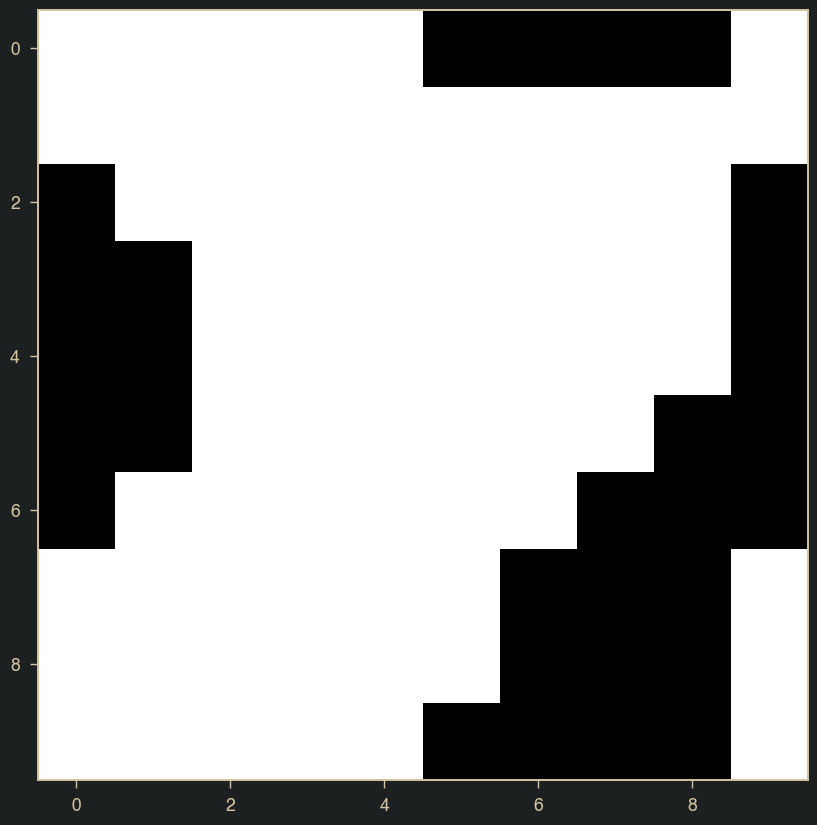

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(1-train_datas_10[0], 'gray')
plt.savefig('CA.png')
plt.show()

In [16]:
def create_cnn10(input_shape=(10, 10, 1), num_classes=10):
    model = models.Sequential()
   
    # 1st Convolution Block
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # 2nd Convolution Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    # Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
   
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
   
    return model

input_shape = (10, 10, 1)
num_classes = 10
model_10 = create_cnn10(input_shape, num_classes)
model_10.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 48)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 10, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 10, 10, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,154 (406.85 KB)

 Trainable params: 103,578 (404.60 KB)

 Non-trainable params: 576 (2.25 KB)

In [17]:
model_10.compile(optimizer=Adam(learning_rate = 0.01),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [18]:
history_10 = model_10.fit(train_datas_10, train_labels_10, epochs = 70, validation_data = (test_datas_10, test_labels_10))

Epoch 1/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.2424 - loss: 1.8930 - val_accuracy: 0.2403 - val_loss: 1.8371
Epoch 2/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2767 - loss: 1.6922 - val_accuracy: 0.3088 - val_loss: 1.5894
Epoch 3/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2848 - loss: 1.6647 - val_accuracy: 0.3062 - val_loss: 1.5917
Epoch 4/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2842 - loss: 1.6539 - val_accuracy: 0.3064 - val_loss: 1.5883
Epoch 5/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2938 - loss: 1.6485 - val_accuracy: 0.2980 - val_loss: 1.6114
Epoch 6/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2951 - loss: 1.6410 - val_accuracy: 0.2996 - val_loss: 1.6066
Epoch 7/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.3007 - loss: 1.6369 - val_accuracy: 0.3030 - val_loss: 1.5919
Epoch 8/70
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.3019 -

Max test accuracy =  0.32405999302864075


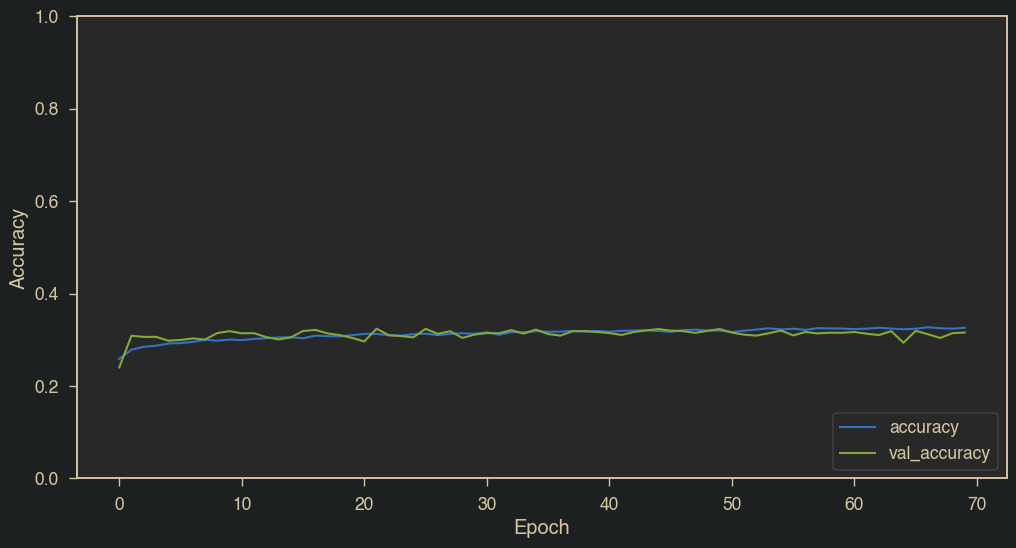

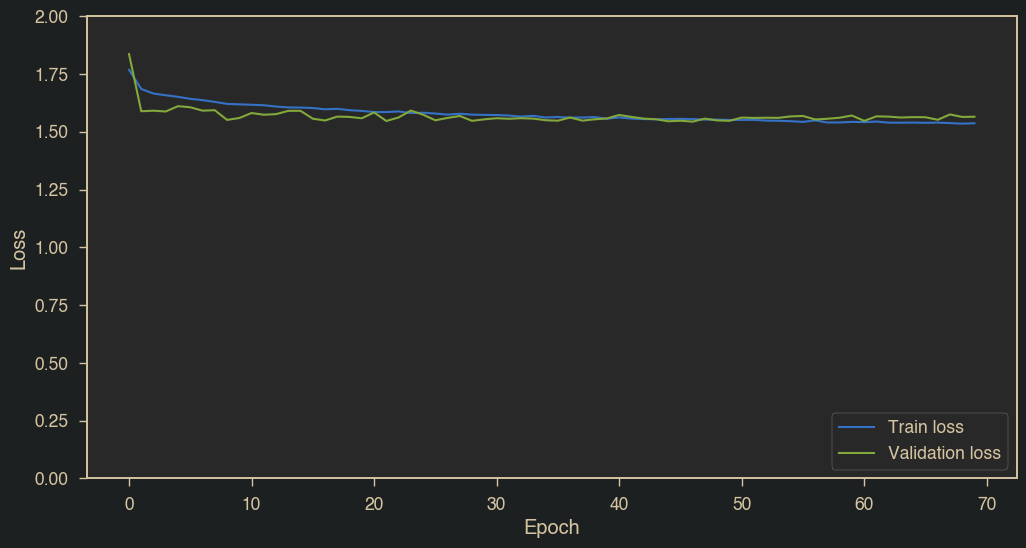

In [19]:
plot_results(history_10)

In [20]:
Evaluate = model_10.evaluate(test_datas_10, test_labels_10)
print('Test accuracy = ', Evaluate[1])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.3139 - loss: 1.5630
Test accuracy =  0.3157399892807007


In [21]:
predictions = model_10.predict(test_datas_10)
predicted_labels = np.argmax(predictions, axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


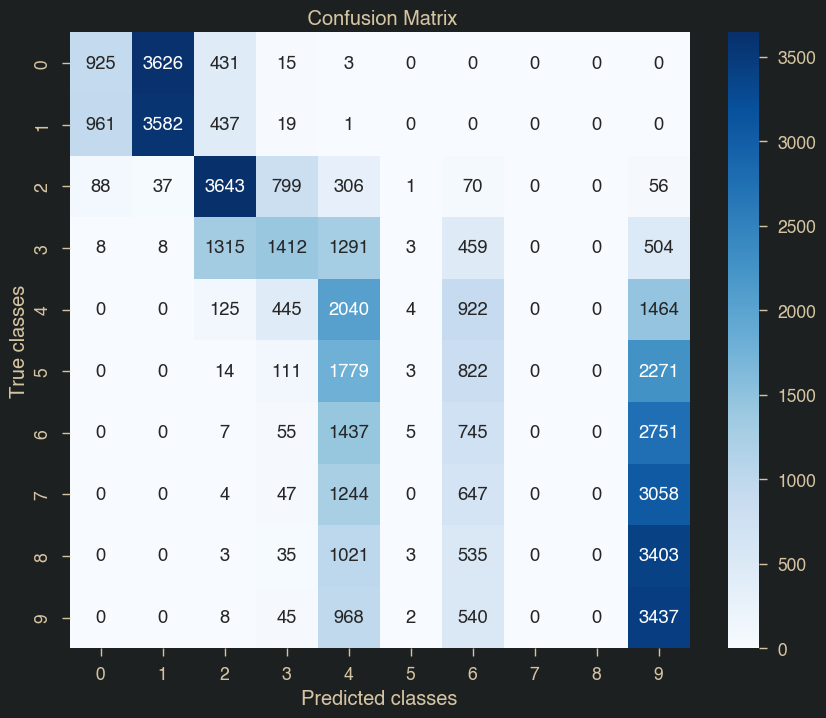

In [22]:
num_classes = 10
class_indices = np.arange(num_classes)  
predicted_labels = class_indices[predicted_labels]

cm = confusion_matrix(test_labels_10, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title(' Confusion Matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()

# For Domain size 50$\times$50

In [23]:
def load_data(generation_size, seq=1):
    labels = []
    datas = []
    for sigma in range(10):
        with open(f"OUTPUT50_PK/cam_sigma{sigma}_{generation_size}.pk",'rb') as file:
            data = pickle.load(file)
        n = data.shape[0]
        label = np.ones(n, dtype=int) * sigma

        datas.append(data)
        labels.append(label)

    datas = np.concatenate(datas)
    labels = np.concatenate(labels)
    
#     datas = datas[:, 0:seq, :]
    datas[datas>0] = 1

    datas = datas.reshape(n*10,-1,50,50)
    datas = datas.transpose((0,2,3,1))
    
    return datas, labels

In [25]:
train_datas_50, train_labels_50 = load_data('samples5000', seq=1)
test_datas_50,  test_labels_50  = load_data('samples4000', seq=1)


train_datas_50, train_labels_50 = shuffle(train_datas_50, train_labels_50, random_state=42)
test_datas_50, test_labels_50 = shuffle(test_datas_50, test_labels_50, random_state=42)

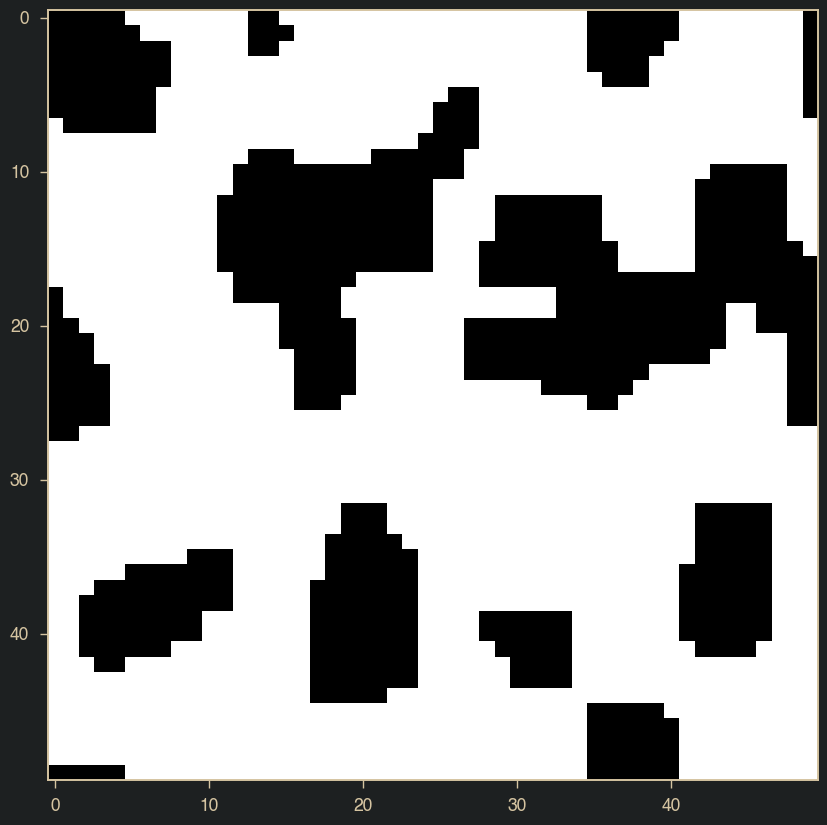

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(1-train_datas_50[0], 'gray')
plt.show()

In [27]:
def create_cnn50(input_shape=(10, 10, 1), num_classes=10):
    model = models.Sequential()
   
    # 1st Convolution Block
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # 2nd Convolution Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    # Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
   
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
   
    return model

input_shape = (50, 50, 1)
num_classes = 10
model_50 = create_cnn50(input_shape, num_classes)
model_50.summary()

/Users/ouragadavid/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 48)     │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 50, 50, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 50, 50, 48)     │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 50, 50, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 25, 64)     │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │       147,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 234,506 (916.04 KB)

 Trainable params: 234,026 (914.16 KB)

 Non-trainable params: 480 (1.88 KB)

In [28]:
model_50.compile(optimizer=Adam(learning_rate = 0.01),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [29]:
history_50 = model_50.fit(train_datas_50, train_labels_50, epochs = 70, validation_data = (test_datas_50, test_labels_50))

Epoch 1/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 45ms/step - accuracy: 0.3975 - loss: 1.3910 - val_accuracy: 0.3881 - val_loss: 1.6909
Epoch 2/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.5049 - loss: 1.0430 - val_accuracy: 0.2866 - val_loss: 2.1348
Epoch 3/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.5208 - loss: 1.0008 - val_accuracy: 0.5699 - val_loss: 0.8614
Epoch 4/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 46ms/step - accuracy: 0.5362 - loss: 0.9654 - val_accuracy: 0.3161 - val_loss: 1.4799
Epoch 5/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.5426 - loss: 0.9496 - val_accuracy: 0.5207 - val_loss: 0.9081
Epoch 6/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.5443 - loss: 0.9467 - val_accuracy: 0.4931 - val_loss: 0.9975
Epoch 7/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.5505 - loss: 0.9384 - val_accuracy: 0.5480 - val_loss: 0.9068
Epoch 8/70
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.5558 -

Max test accuracy =  0.6758750081062317


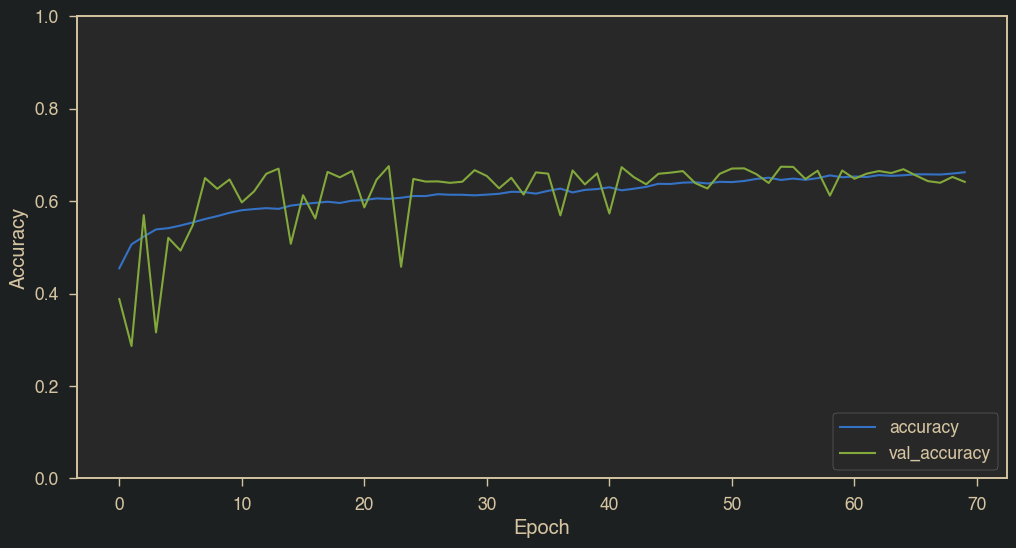

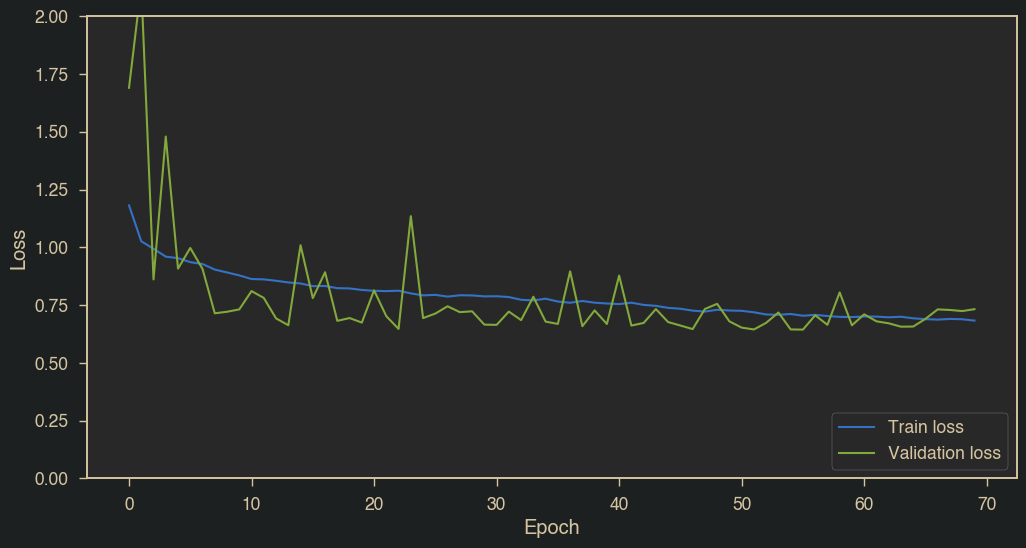

In [30]:
plot_results(history_50)

In [31]:
Evaluate = model_50.evaluate(test_datas_50, test_labels_50)
print('Test accuracy = ', Evaluate[1])

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6434 - loss: 0.7254
Test accuracy =  0.6418250203132629


In [32]:
predictions = model_50.predict(test_datas_50)
predicted_labels = np.argmax(predictions, axis=1)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


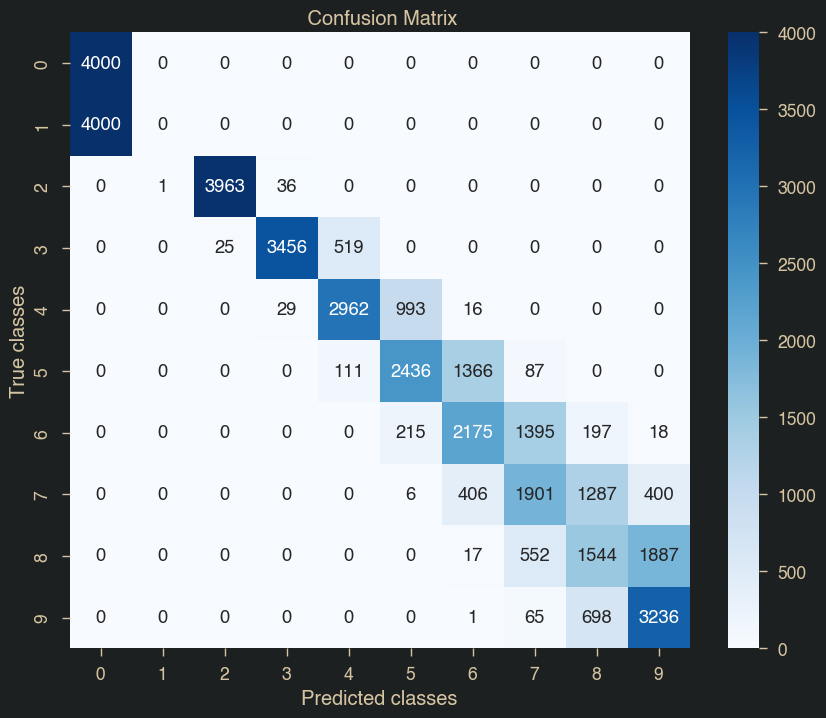

In [33]:
num_classes = 10
class_indices = np.arange(num_classes)  
predicted_labels = class_indices[predicted_labels]

cm = confusion_matrix(test_labels_50, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title(' Confusion Matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()

# For Domain size 100$\times$100

In [37]:
def load_data(generation_size, seq=1):
    labels = []
    datas = []
    for sigma in range(10):
        with open(f"OUTPUT100_PK/cam_sigma{sigma}_{generation_size}.pk",'rb') as file:
            data = pickle.load(file)
        n = data.shape[0]
        label = np.ones(n, dtype=int) * sigma

        datas.append(data)
        labels.append(label)

    datas = np.concatenate(datas)
    labels = np.concatenate(labels)
    
    datas = datas[:, 0:seq, :]
    datas[datas>0] = 1

    datas = datas.reshape(n*10,-1,100,100)
    datas = datas.transpose((0,2,3,1))
    
    return datas, labels

In [38]:
train_datas, train_labels = load_data('samples3000', seq=1)
test_datas,  test_labels  = load_data('samples2000', seq=1)


train_datas, train_labels = shuffle(train_datas, train_labels, random_state=42)
test_datas, test_labels = shuffle(test_datas, test_labels, random_state=42)

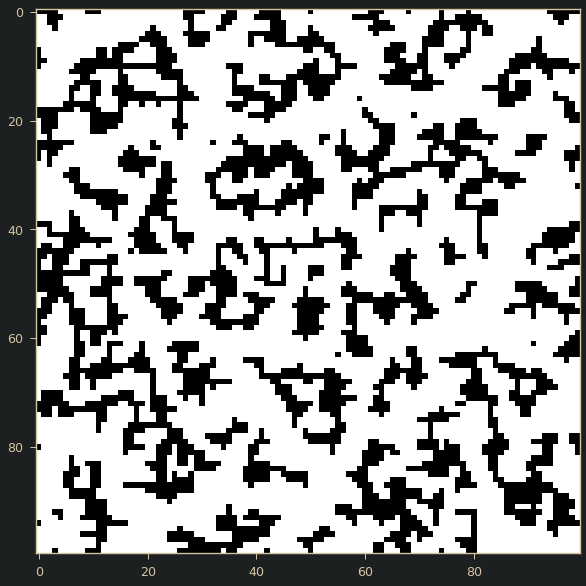

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(1-train_datas[0], 'gray')
plt.show()

In [40]:
def create_cnn(input_shape=(100, 100, 1), num_classes=10):
    model = models.Sequential()
   
    # 1st Convolution Block
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.3))

    # 2nd Convolution Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    # Fully Connected Layer
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
   
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
   
    return model

input_shape = (100, 100, 1)
num_classes = 10
model = create_cnn(input_shape, num_classes)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 100, 100, 48)      480       
                                                                 
 batch_normalization_15 (Bat  (None, 100, 100, 48)     192       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 48)      20784     
                                                                 
 batch_normalization_16 (Bat  (None, 100, 100, 48)     192       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 48)       0         
 2D)                                                             
                                                      

In [41]:
model.compile(optimizer=Adam(learning_rate = 0.0005),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [42]:
history = model.fit(train_datas, train_labels, epochs = 50, validation_data = (test_datas, test_labels))

Epoch 1/50
938/938 [==============================] - 203s 215ms/step - loss: 1.6815 - accuracy: 0.3124 - val_loss: 2.3743 - val_accuracy: 0.3135
Epoch 2/50
938/938 [==============================] - 198s 211ms/step - loss: 1.1949 - accuracy: 0.4742 - val_loss: 0.9390 - val_accuracy: 0.5454
Epoch 3/50
938/938 [==============================] - 196s 209ms/step - loss: 0.9746 - accuracy: 0.5688 - val_loss: 1.2527 - val_accuracy: 0.3717
Epoch 4/50
938/938 [==============================] - 197s 210ms/step - loss: 0.8761 - accuracy: 0.5961 - val_loss: 0.7047 - val_accuracy: 0.6731
Epoch 5/50
938/938 [==============================] - 197s 210ms/step - loss: 0.8196 - accuracy: 0.6145 - val_loss: 0.5979 - val_accuracy: 0.7025
Epoch 6/50
938/938 [==============================] - 197s 210ms/step - loss: 0.7773 - accuracy: 0.6310 - val_loss: 0.5776 - val_accuracy: 0.7164
Epoch 7/50
938/938 [==============================] - 196s 209ms/step - loss: 0.7469 - accuracy: 0.6410 - val_loss: 0.7516 -

Max test accuracy =  0.8003000020980835


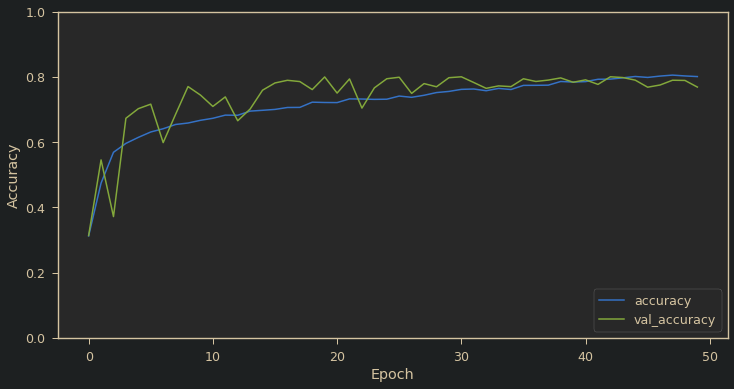

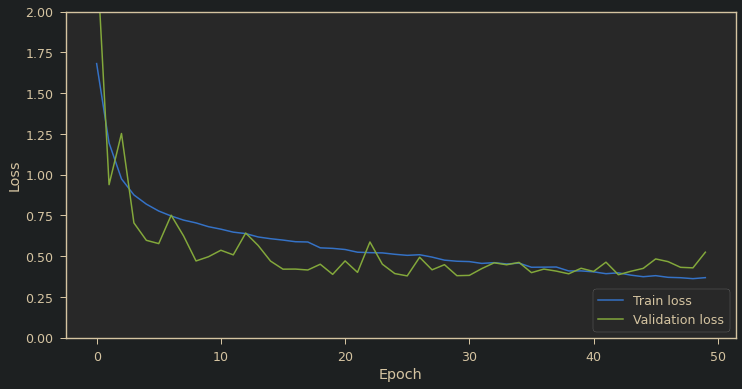

In [43]:
plot_results(history)

In [44]:
Evaluate = model.evaluate(test_datas, test_labels)
print('Test accuracy = ', Evaluate[1])

625/625 [==============================] - 40s 64ms/step - loss: 0.5249 - accuracy: 0.7688
Test accuracy =  0.768750011920929


In [45]:
predictions = model.predict(test_datas)
predicted_labels = np.argmax(predictions, axis=1)


625/625 [==============================] - 40s 64ms/step


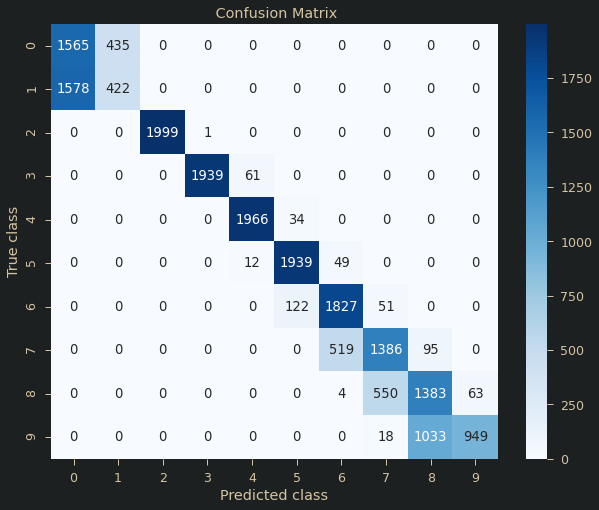

In [46]:
num_classes = 10
class_indices = np.arange(num_classes)  
predicted_labels = class_indices[predicted_labels]

cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.title(' Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()